In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyhessian import hessian

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'mps'

In [4]:
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')

data = data[data['label'].isin([0, 1])]
test = test[test['label'].isin([0, 1])]

X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(1, device=device)[Y_temp]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(1, device=device)[Y_temp]

In [5]:
gen = torch.Generator(device=device)
gen.manual_seed(123)

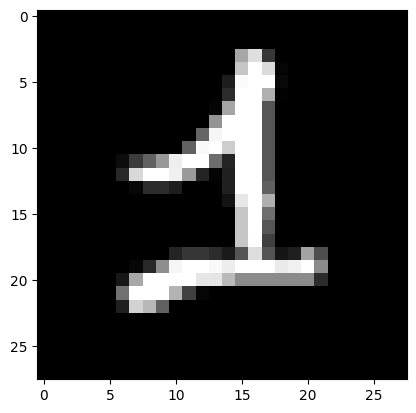

In [6]:
plt.imshow(X[7].view(28,28).cpu(), cmap='gray')

In [19]:
def permut_row(x, perm):
    return x[perm]

In [20]:
n_tasks = 3
tasks = []
tasks_test = []

for _ in range(n_tasks):
        perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=perm)).to(device))

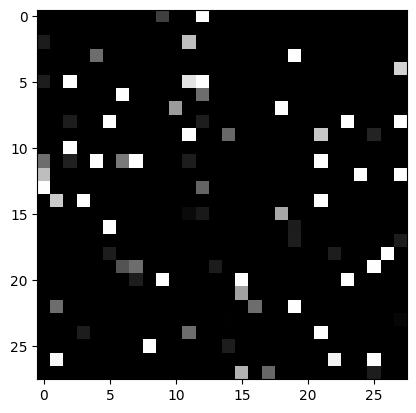

In [23]:
plt.imshow(tasks[1][4].cpu().view(28,28), cmap='gray')

In [ ]:
from torchsummary import summary

class MLP(nn.Module):
    """Standard MLP"""
    def __init__(self, w, L):
        super(MLP, self).__init__()
        self.w = w
        self.fc1 = nn.Linear(784, self.w, bias=False)
        self.layers = nn.ModuleList(nn.Linear(self.w,self.w, bias=False) for _ in range(L))
        self.fc2 = nn.Linear(self.w, 1, bias=False)
        self.relu = nn.ReLU()
        self.L = L

    def forward(self, x):
        x = self.fc1(x)
        for l in self.layers:
            x = l(x)
        x = self.fc2(x)
        #x = x/np.sqrt(self.w*784)

        return x
    
N = 128

mlp = MLP(N, 4)
summary(mlp, (1,784))
mlp = mlp.to(device)

In [ ]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=2/256)

In [ ]:
def top_eigen(model, loss, X, Y, prt=False):

    hess_comp = hessian(model, loss, (X,Y) )
    top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
        
    return top_eigenvalues[-1] , top_eigenvector

In [ ]:
MSE = nn.MSELoss()

s, _ = top_eigen(mlp, MSE , X, Y)
print(s)

In [ ]:
def GSalign(model, eigen):
   z = 0
   for g,p in zip(model.parameters(), eigen[0]):
        if g.requires_grad:
          gd = g.grad
          z += torch.sum(gd*p)/(torch.sqrt(torch.sum(gd*gd))*torch.sqrt(torch.sum(p*p))*len(eigen[0]))

   return z.item()

def little_ev(model):
   
   E = dict(model.named_parameters())['fc1.weight']
   V = dict(model.named_parameters())['fc2.weight']

   e = (E.T @ E)/(E.shape[0]*E.shape[1])
   v = torch.sum((V @ V.T)/(E.shape[0]*E.shape[1]))

   return e, v


In [ ]:
loss_hist = []
lam = []
all = []
batch = len(X)

for epoch in range(50):

        running_loss = 0.0
        for i in range(len(X)//batch):

            # Batch of training 
            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

            ixc = torch.randint(0, len(X), (2048,), generator=gen, device=device)
            sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])

            optimizer.zero_grad()

            out = mlp(X[ix])
            loss = MSE(out, Y[ix])
            loss.backward()
            running_loss += loss.item()

            all.append(GSalign(mlp,eigen))

            optimizer.step()

            lam.append(sharp)
            loss_hist.append(loss.item())

            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f} -----> sharpness = {sharp:.3f}')

            if epoch == 349:
                  sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])
                  task1_eigen = eigen
                  

print('Finished Training')

acc = []
acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,8))

ax[0].plot(lam)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Sharpness')

ax[1].plot(loss_hist)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss')

ax[2].plot(np.arccos(all)*180/np.pi, linestyle=':', marker='.')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Alignment angle Grad-Sharp')
ax[2].axhline(90, color='r', linestyle='dotted')
plt.show()

In [ ]:
acc = []
acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

In [ ]:
acc

In [ ]:
hess_comp = hessian( mlp, MSE, (X,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()

print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[0])

In [ ]:
hess_comp = hessian(mlp, MSE, (X_perm,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is", top_eigenvalues[0])

In [ ]:
lr = 2/256
optimizer = torch.optim.SGD(mlp.parameters(), lr=lr)

old_loss = []
batch = 1
forg = []
term1 = []
term2 = []
delta1 = [(mlp(X)[0]-Y[0]).item()]
delta2 = [(mlp(X_perm)[0]-Y[0]).item()]

In [ ]:
def forget(model,X1,Y1,X2,Y2,gam,lr, delta1, delta2):

    e, v = little_ev(model)

    term1 = N*784*(( X1 @ (e @ X2.T) + (X1 @ X2.T) * v) * delta2 * lr)

    term2 = (X1 @ X2.T) @ model(X2) * delta2**2 * lr**2

    f = (delta1 - (term1 - term2))

    return f.item(), term1.item(), term2.item()

In [ ]:

for Xt in tasks:
        
        for epoch in range():

                running_loss = 0.0
                for i in range(1000):

                    # Batch of training 
                    ix = torch.randint(0, len(Xt), (batch,), generator=gen, device=device)

                    #ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)
                    #sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])

                    optimizer.zero_grad()
        
                    out = mlp(Xt[ix])
                    loss = MSE(out, Y[ix])
                    loss.backward()
                    running_loss += loss.item()

                    all.append(GSalign(mlp,eigen))

                    #f, t1, t2 = forget(mlp, X[ix], Y[ix], X_perm[ix], Y[ix], 0, lr, delta1[-1], delta2[-1] )
                    #forg.append(f)
                    #term1.append(t1)
                    #term2.append(t2)
                    #eigenvalues, eigenvectors = np.linalg.eigh(e.cpu().detach().numpy())
                    #e_hist_max.append(eigenvalues[-1])
                    #e_hist_min.append(eigenvalues[0])
            
                    optimizer.step()

                    #delta1.append((mlp(X[ix])-Y[ix]).item())
                    #delta2.append((mlp(X_perm[ix])-Y[ix]).item())
                    lam.append(sharp)
                    loss_hist.append(loss.item())
                    old_loss.append( MSE( mlp(X[ix]), Y[ix]).item() )

                    if i%100 == 0:
                        print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f} -----> sharpness = {sharp:.3f}')

        print('Finished Training')
        acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )


In [ ]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(np.array(old_loss)))
plt.show()

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,8))

ax[0].plot(lam)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Sharpness')
ax[0].axvline(50, color='r', linestyle='dotted')
ax[0].axhline(4, color='r', linestyle='dotted')


ax[1].plot(loss_hist)
ax[1].plot(np.arange(50,50+1000),old_loss, color='red')
ax[1].plot(np.arange(50,50+1000),forg, color='orange')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss')
ax[1].axvline(50, color='r', linestyle='dotted')

ax[2].plot(np.arccos(all)*180/np.pi, linestyle=':', marker='.')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Alignment angle Grad-Sharp')
ax[2].axvline(50, color='r', linestyle='dotted')
ax[2].axhline(90, color='r', linestyle='dotted')
plt.show()


In [ ]:
plt.figure(figsize=(15,8))
plt.plot(forg[0:15], label='forg', linestyle='dashed')
plt.plot(delta1[1:16], label='delta1', alpha= 0.6)
plt.plot(term1[0:15], label='term1', alpha= 0.6)
plt.plot(term2[0:15], label='term2', alpha= 0.6)

#plt.plot(term1[:120], label='term1' )
#plt.plot(term2[:120], label='term2')
plt.legend()
plt.show()

In [ ]:
print(delta1[:5])
print(term1[:5])
print(term2[:5])
print(forg[:5])
print(old_loss[:5])

In [ ]:
plt.plot(torch.tensor(delta1).cpu())
plt.plot(torch.tensor(delta2).cpu())
plt.show()

In [ ]:
ratio_term = torch.tensor((term1)/(np.array(term2)+1E-10))
counts, bins = torch.histogram(ratio_term, range=(-10000,10000))
plt.stairs(counts, bins)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(term1,term2,c = range(len(term1)), marker='+')
clb = plt.colorbar()
clb.ax.set_title('GD time step index')
plt.show()

In [ ]:
negative_values = [(index, value) for index, value in enumerate(term1) if value < 0]

plt.figure(figsize=(10, 6))
plt.plot(range(len(term1)), term1, label='term1')
plt.scatter([index for index, _ in negative_values], [value for _, value in negative_values], color='red', label='Negative Terms', marker='+')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
negative_values = [(index, value) for index, value in enumerate(term2) if value < 0]

plt.figure(figsize=(10, 6))
plt.plot(range(len(term2)), term2, label='term2')
plt.scatter([index for index, _ in negative_values], [value for _, value in negative_values], color='red', label='Negative Terms', marker='+')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
diff = np.array(term1)-np.array(term2)

In [ ]:
negative_values = [(index, value) for index, value in enumerate(diff) if value < 0]

plt.figure(figsize=(10, 6))
plt.plot(range(len(diff)), diff, label='term2')
plt.scatter([index for index, _ in negative_values], [value for _, value in negative_values], color='red', label='Negative Terms', marker='+')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(e_hist_max)
plt.show()
plt.plot(e_hist_min, color='red')
plt.show()

In [ ]:
torch.sum(torch.argmax(mlp(X_test_perm), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)

In [ ]:
acc

In [ ]:
counts, bins = torch.histogram(torch.tensor(all[:350]), 50)
counts1, bins1 = torch.histogram(torch.tensor(all[350:]), 50)

In [ ]:
plt.stairs(counts, bins)
plt.show()
plt.stairs(counts1, bins1)
plt.show()